# Just an example.You can alter sample code anywhere.

## mount your google drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # You need to modify this part to the directory where your code is located
# %cd "/content/drive/MyDrive/DL_Lab1/"

## Import packages


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import model
from model import Adam
from model import CosineAnnealingScheduler
import pickle
import math
from tqdm import tqdm
import os

In [4]:
#Fix the random seed
np.random.seed(0)

## Load the data and label

In [5]:
# Use dataset : Kuzushiji-MNIST
train_load = np.loadtxt('C:/Users/User/Downloads/data/kmnist-train.csv',delimiter=',',dtype="int")
test_load = np.loadtxt('C:/Users/User/Downloads/data/kmnist-test.csv',delimiter=',',dtype="int")

train_data=train_load[:,1:]
train_label=train_load[:,0]
test_data=test_load
print("shape of train_data: {}".format(train_data.shape))
print("shape of train_label: {}".format(train_label.shape))
print("shape of test_data: {}".format(test_data.shape))

shape of train_data: (60000, 784)
shape of train_label: (60000,)
shape of test_data: (10000, 784)


## Show the training data

In [6]:
# #uncomment if you want to show the training data
# plt.figure(figsize=(20, 20))
# for index in range(10):
#    image = train_data[index+1000].reshape(28,28)
#    plt.subplot(2, 5, index+1)
#    plt.imshow(image)
# plt.show()

In [7]:
train_image_num = train_data.shape[0]
test_image_num = test_data.shape[0]
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

print("train_image_num  is : {}".format(train_image_num))
print("test_image_num   is : {}".format(test_image_num))

train_image_num  is : 60000
test_image_num   is : 10000


## Validation image number

In [8]:
val_image_num=10000

## Convert the training labels to one hot vector

In [9]:
label_temp = np.zeros((train_image_num, 10), dtype = np.float32)
for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)
print("One-hot training labels shape:",train_label_onehot.shape)

One-hot training labels shape: (60000, 10)


## Hyperparameters

In [10]:
EPOCH = 20
Batch_size = 100 # 10000 should be divisible by batch_size
Learning_rate = 0.001
train_batch_num = (train_image_num - val_image_num) // Batch_size
val_batch_num = val_image_num // Batch_size

optimizer = Adam(learning_rate=Learning_rate)
scheduler = CosineAnnealingScheduler(lr_0=0.001, T_max=train_batch_num*EPOCH, eta_min=0.0001)

## Training

In [11]:
net = model.Network()
best_val_loss = float('inf')
best_model_path = "best_model.pkl"
history = []

# Check if a best model exists and load it
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    with open(best_model_path, 'rb') as f:
        net = pickle.load(f)
else:
    print("No saved model found, start training.")

for epoch in range(1, EPOCH + 1):
    train_hit, val_hit = 0, 0
    total_train_loss, total_val_loss = 0.0, 0.0
    lrs = []
    result = {'train_loss': [], 'valid_loss': [], 'lrs': []}

    # Use tqdm for tracking progress during training
    with tqdm(total=train_batch_num, desc=f"Epoch {epoch}/{EPOCH}", unit="batch") as pbar:
        for it in range(train_batch_num):
            batch_start = it * Batch_size
            batch_end = (it + 1) * Batch_size
            
            train_batch = train_data[batch_start:batch_end]
            train_label_batch = train_label[batch_start:batch_end]
            
            train_label_int = np.argmax(train_label_onehot[batch_start:batch_end], axis=1)

            pred, train_loss = net.forward(train_batch, train_label_int)
            pred_index = np.argmax(pred, axis=1)
            train_hit += (pred_index == train_label_batch).sum()
            total_train_loss += train_loss

            net.backward()

            current_lr = scheduler.get_lr()
            net.update(lr=current_lr)

            lrs.append(current_lr)

            scheduler.step()

            pbar.set_postfix({
                "Train Loss": total_train_loss / (it + 1),
                "Train Acc": train_hit / ((it + 1) * Batch_size) * 100.0,
            })
            pbar.update(1)

    # Use tqdm for tracking progress during validation
    for titt in range(val_batch_num):
        batch_start = (train_batch_num + titt) * Batch_size
        batch_end = (train_batch_num + titt + 1) * Batch_size
        
        val_batch = train_data[batch_start:batch_end]
        val_label_batch = train_label[batch_start:batch_end]
        
        valid_label_int = np.argmax(train_label_onehot[batch_start:batch_end], axis=1)
        
        pred, val_loss = net.forward(val_batch, valid_label_int)
        pred_index = np.argmax(pred, axis=1)
        val_hit += (pred_index == val_label_batch).sum()
        total_val_loss += val_loss

    train_acc = train_hit / (train_image_num - val_image_num) * 100.0
    val_acc = val_hit / val_image_num * 100.0
    avg_train_loss = total_train_loss / train_batch_num
    avg_val_loss = total_val_loss / val_batch_num

    result['train_loss'] = avg_train_loss
    result['valid_loss'] = avg_val_loss
    result['lrs'] = lrs
    history.append(result)

    print(f'Task1  | Epoch: {epoch:3d} | Train Loss: {avg_train_loss:8.4f} | Train Acc: {train_acc:3.4f} | Val Loss: {avg_val_loss:8.4f} | Val Acc: {val_acc:3.4f}')
    
    # If the current validation loss is better, save the model
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print(f"New best model found at epoch {epoch}, saving model with Val_loss: {avg_val_loss:.4f}")
        with open(best_model_path, 'wb') as f:
            pickle.dump(net, f)

print(f"Training complete. Best model saved with Val_loss: {best_val_loss / val_batch_num:.4f} at {best_model_path}")

No saved model found, start training.


Epoch 1/20: 100%|██████████| 500/500 [16:05<00:00,  1.93s/batch, Train Loss=1.95, Train Acc=59.6]


Task1  | Epoch:   1 | Train Loss:   1.9469 | Train Acc: 59.6020 | Val Loss:   1.6179 | Val Acc: 72.1000
New best model found at epoch 1, saving model with Val_loss: 1.6179


Epoch 2/20: 100%|██████████| 500/500 [23:35<00:00,  2.83s/batch, Train Loss=1.37, Train Acc=74.9]


Task1  | Epoch:   2 | Train Loss:   1.3716 | Train Acc: 74.8600 | Val Loss:   1.1300 | Val Acc: 79.8000
New best model found at epoch 2, saving model with Val_loss: 1.1300


Epoch 3/20: 100%|██████████| 500/500 [15:07<00:00,  1.81s/batch, Train Loss=0.981, Train Acc=81.9]


Task1  | Epoch:   3 | Train Loss:   0.9814 | Train Acc: 81.8920 | Val Loss:   0.8202 | Val Acc: 85.1500
New best model found at epoch 3, saving model with Val_loss: 0.8202


Epoch 4/20: 100%|██████████| 500/500 [15:06<00:00,  1.81s/batch, Train Loss=0.735, Train Acc=86.1]


Task1  | Epoch:   4 | Train Loss:   0.7347 | Train Acc: 86.1160 | Val Loss:   0.6300 | Val Acc: 88.3400
New best model found at epoch 4, saving model with Val_loss: 0.6300


Epoch 5/20: 100%|██████████| 500/500 [15:06<00:00,  1.81s/batch, Train Loss=0.582, Train Acc=88.9]


Task1  | Epoch:   5 | Train Loss:   0.5823 | Train Acc: 88.9460 | Val Loss:   0.5123 | Val Acc: 90.5000
New best model found at epoch 5, saving model with Val_loss: 0.5123


Epoch 6/20: 100%|██████████| 500/500 [15:07<00:00,  1.81s/batch, Train Loss=0.485, Train Acc=90.8]


Task1  | Epoch:   6 | Train Loss:   0.4854 | Train Acc: 90.8120 | Val Loss:   0.4353 | Val Acc: 92.0700
New best model found at epoch 6, saving model with Val_loss: 0.4353


Epoch 7/20: 100%|██████████| 500/500 [15:06<00:00,  1.81s/batch, Train Loss=0.42, Train Acc=92.1] 


Task1  | Epoch:   7 | Train Loss:   0.4202 | Train Acc: 92.0760 | Val Loss:   0.3831 | Val Acc: 92.9700
New best model found at epoch 7, saving model with Val_loss: 0.3831


Epoch 8/20: 100%|██████████| 500/500 [15:07<00:00,  1.81s/batch, Train Loss=0.375, Train Acc=92.9]


Task1  | Epoch:   8 | Train Loss:   0.3746 | Train Acc: 92.8560 | Val Loss:   0.3461 | Val Acc: 93.5100
New best model found at epoch 8, saving model with Val_loss: 0.3461


Epoch 9/20: 100%|██████████| 500/500 [15:07<00:00,  1.81s/batch, Train Loss=0.341, Train Acc=93.5]


Task1  | Epoch:   9 | Train Loss:   0.3415 | Train Acc: 93.4820 | Val Loss:   0.3192 | Val Acc: 93.8300
New best model found at epoch 9, saving model with Val_loss: 0.3192


Epoch 10/20: 100%|██████████| 500/500 [15:08<00:00,  1.82s/batch, Train Loss=0.317, Train Acc=93.9]


Task1  | Epoch:  10 | Train Loss:   0.3169 | Train Acc: 93.9340 | Val Loss:   0.2991 | Val Acc: 94.2300
New best model found at epoch 10, saving model with Val_loss: 0.2991


Epoch 11/20: 100%|██████████| 500/500 [15:07<00:00,  1.82s/batch, Train Loss=0.298, Train Acc=94.2]


Task1  | Epoch:  11 | Train Loss:   0.2982 | Train Acc: 94.2260 | Val Loss:   0.2840 | Val Acc: 94.4800
New best model found at epoch 11, saving model with Val_loss: 0.2840


Epoch 12/20: 100%|██████████| 500/500 [15:07<00:00,  1.82s/batch, Train Loss=0.284, Train Acc=94.5]


Task1  | Epoch:  12 | Train Loss:   0.2838 | Train Acc: 94.4840 | Val Loss:   0.2719 | Val Acc: 94.7100
New best model found at epoch 12, saving model with Val_loss: 0.2719


Epoch 13/20: 100%|██████████| 500/500 [15:06<00:00,  1.81s/batch, Train Loss=0.273, Train Acc=94.7]


Task1  | Epoch:  13 | Train Loss:   0.2725 | Train Acc: 94.6780 | Val Loss:   0.2626 | Val Acc: 94.7900
New best model found at epoch 13, saving model with Val_loss: 0.2626


Epoch 14/20: 100%|██████████| 500/500 [15:10<00:00,  1.82s/batch, Train Loss=0.264, Train Acc=94.8]


Task1  | Epoch:  14 | Train Loss:   0.2638 | Train Acc: 94.7920 | Val Loss:   0.2554 | Val Acc: 94.9400
New best model found at epoch 14, saving model with Val_loss: 0.2554


Epoch 15/20: 100%|██████████| 500/500 [15:07<00:00,  1.81s/batch, Train Loss=0.257, Train Acc=94.9]


Task1  | Epoch:  15 | Train Loss:   0.2569 | Train Acc: 94.9340 | Val Loss:   0.2498 | Val Acc: 94.9900
New best model found at epoch 15, saving model with Val_loss: 0.2498


Epoch 16/20: 100%|██████████| 500/500 [15:07<00:00,  1.81s/batch, Train Loss=0.252, Train Acc=95]  


Task1  | Epoch:  16 | Train Loss:   0.2516 | Train Acc: 95.0240 | Val Loss:   0.2455 | Val Acc: 95.0500
New best model found at epoch 16, saving model with Val_loss: 0.2455


Epoch 17/20: 100%|██████████| 500/500 [15:08<00:00,  1.82s/batch, Train Loss=0.247, Train Acc=95.1]


Task1  | Epoch:  17 | Train Loss:   0.2474 | Train Acc: 95.1220 | Val Loss:   0.2421 | Val Acc: 95.0900
New best model found at epoch 17, saving model with Val_loss: 0.2421


Epoch 18/20: 100%|██████████| 500/500 [15:03<00:00,  1.81s/batch, Train Loss=0.244, Train Acc=95.2]


Task1  | Epoch:  18 | Train Loss:   0.2442 | Train Acc: 95.1840 | Val Loss:   0.2395 | Val Acc: 95.1800
New best model found at epoch 18, saving model with Val_loss: 0.2395


Epoch 19/20: 100%|██████████| 500/500 [15:08<00:00,  1.82s/batch, Train Loss=0.242, Train Acc=95.2]


Task1  | Epoch:  19 | Train Loss:   0.2416 | Train Acc: 95.2180 | Val Loss:   0.2375 | Val Acc: 95.2200
New best model found at epoch 19, saving model with Val_loss: 0.2375


Epoch 20/20: 100%|██████████| 500/500 [15:39<00:00,  1.88s/batch, Train Loss=0.24, Train Acc=95.3] 


Task1  | Epoch:  20 | Train Loss:   0.2395 | Train Acc: 95.2600 | Val Loss:   0.2356 | Val Acc: 95.2500
New best model found at epoch 20, saving model with Val_loss: 0.2356
Training complete. Best model saved with Val_loss: 0.2356 at best_model.pkl


# Plotting

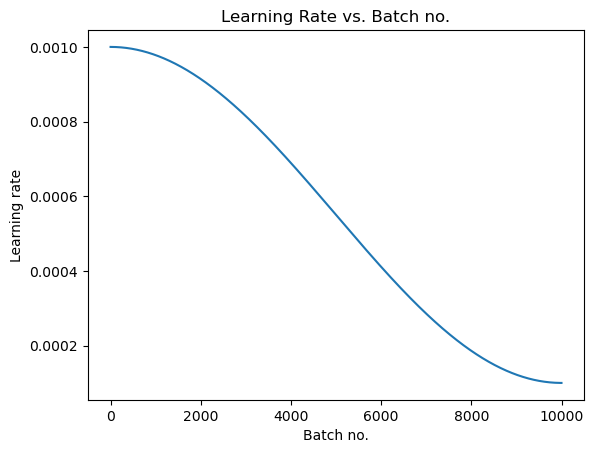

In [12]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

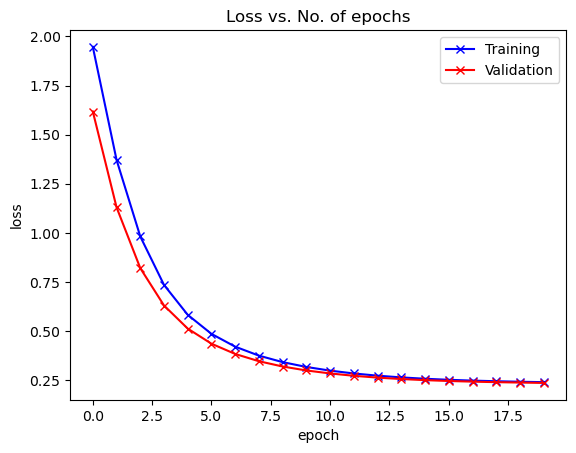

In [13]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_losses(history)

## Dump for evaluation (upload your DL-test-predict.csv to kaggle )

In [14]:
with open(best_model_path, 'rb') as f:
    net = pickle.load(f)

test_pred_list = []
total_test = 0
for tit in range(test_image_num//Batch_size):
    test_label_int = np.argmax(train_label_onehot[tit*Batch_size:(tit+1)*Batch_size], axis=1)
    pred, _ = net.forward(test_data[tit*Batch_size:(tit+1)*Batch_size], test_label_int)
    pred_index = np.argmax(pred, axis=1)
    test_pred_list += pred_index.tolist()
    total_test += Batch_size

print('Please make sure that total test images = 10000')
print(f'Total test images: {total_test} ')

print('Dump file...')
df = pd.DataFrame(test_pred_list, columns=["Category"])
df.to_csv('DL-test-predict.csv', index=True, index_label="Id")

Please make sure that total test images = 10000
Total test images: 10000 
Dump file...
